## Graph Dynamical Systems

This notebooks contains the experiments to evaluate graph edit networks on simple graph dynamical systems, namely the edit cycles, degree rules, and game of life datasets.

### Hyperparameter setup

In [1]:
import time
import numpy as np
import torch
import pytorch_graph_edit_networks as gen
import baseline_models
import hep_th

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# model hyperparameters
num_layers = 2
dim_hid = 64

# training hyperparameters
learning_rate  = 1E-3
weight_decay   = 1E-5
loss_threshold = 1E-3
max_epochs     = 10000
print_step     = 1000

# the number of repitions for each experiment
R = 3
# the number of test time series we use to evaluate learning afterwards
N_test = 100

## Model setup

In [2]:
# set up model names
models = ['VGAE', 'GEN_crossent', 'GEN']

# set up functions to initialize the models
def setup_vgae(dim_in, nonlin):
    return baseline_models.VGAE(num_layers = num_layers, dim_in = dim_in, dim_hid = dim_hid, beta = 1E-3, sigma_scaling = 1E-3, nonlin = nonlin)
def setup_gen(dim_in, nonlin):
    return gen.GEN(num_layers = num_layers, dim_in = dim_in, dim_hid = dim_hid, nonlin = nonlin)
setup_funs = [setup_vgae, setup_gen, setup_gen]
# set up functions to compute the loss
loss_fun = gen.GEN_loss()
crossent_loss_fun = gen.GEN_loss_crossent()
def vgae_loss(model, A, X, delta, Epsilon):
    B = A + Epsilon
    # delete all outgoing and incoming edges of deleted nodes
    B[delta < -0.5, :] = 0
    B[:, delta < -0.5] = 0
    return model.compute_loss(torch.tensor(A, dtype=torch.float), torch.tensor(B, dtype=torch.float), torch.tensor(X, dtype=torch.float))
def gen_loss_crossent(model, A, X, delta, Epsilon):
    delta_pred, Epsilon_pred = model(torch.tensor(A, dtype=torch.float), torch.tensor(X, dtype=torch.float))
    return crossent_loss_fun(delta_pred, Epsilon_pred, torch.tensor(delta, dtype=torch.float), torch.tensor(Epsilon, dtype=torch.float), torch.tensor(A, dtype=torch.float))
def gen_loss(model, A, X, delta, Epsilon):
    delta_pred, Epsilon_pred = model(torch.tensor(A, dtype=torch.float), torch.tensor(X, dtype=torch.float))
    return loss_fun(delta_pred, Epsilon_pred, torch.tensor(delta, dtype=torch.float), torch.tensor(Epsilon, dtype=torch.float), torch.tensor(A, dtype=torch.float))
loss_funs = [vgae_loss, gen_loss_crossent, gen_loss]
# set up prediction functions
def vgae_pred(model, A, X):
    B = model(torch.tensor(A, dtype=torch.float), torch.tensor(X, dtype=torch.float))
    B = B.detach().numpy()
    Epsilon = B - A
    delta = np.zeros(A.shape[0])
    delta[np.sum(B, 1) < 0.5] = -1.
    Epsilon[delta < -0.5, :] = 0.
    Epsilon[:, delta < -0.5] = 0.
    return delta, Epsilon
def gen_pred(model, A, X):
    delta_pred, Epsilon_pred = model(torch.tensor(A, dtype=torch.float), torch.tensor(X, dtype=torch.float))
    delta_pred = delta_pred.detach().numpy()
    Epsilon_pred = Epsilon_pred.detach().numpy()
    delta = np.zeros(A.shape[0])
    delta[delta_pred > 0.5] = 1.
    delta[delta_pred < -0.5] = -1.
    Epsilon = np.zeros(A.shape)
    Epsilon[np.logical_and(A > 0.5, Epsilon_pred < -0.5)] = -1.
    Epsilon[np.logical_and(A < 0.5, Epsilon_pred > +0.5)] = +1.
    return delta, Epsilon
pred_funs = [vgae_pred, gen_pred, gen_pred]

eval_criteria = ['node_ins_recall',
                 'node_ins_precision',
                 'node_del_recall',
                 'node_del_precision',
                 'edge_ins_recall',
                 'edge_ins_precision',
                 'edge_del_recall',
                 'edge_del_precision']
# set up a function to compute precision and recall
def prec_rec(X, Y):
    # X is the prediction, Y is the target
    target_insertions = Y > 0.5
    predicted_insertions = X > 0.5
    target_deletions = Y < -0.5
    predicted_deletions = X < -0.5
    # first, check the insertion recall
    if np.sum(target_insertions) < 0.5:
        ins_rec = 1.
    else:
        ins_rec  = np.mean(X[target_insertions] > 0.5)
    # then the insertion precision
    if np.sum(predicted_insertions) < 0.5:
        ins_prec = 1.
    else:
        ins_prec = np.mean(Y[predicted_insertions] > 0.5)
    # then the deletion recall
    if np.sum(target_deletions) < 0.5:
        del_rec = 1.
    else:
        del_rec  = np.mean(X[target_deletions] < -0.5)
    # and finally the deletion precision
    if np.sum(predicted_deletions) < 0.5:
        del_prec = 1.
    else:
        del_prec = np.mean(Y[predicted_deletions] < -0.5)
    return ins_rec, ins_prec, del_rec, del_prec

## Dataset setup

In [5]:
import graph_edit_cycles
import degree_rules
import game_of_life
import random

#datasets = ['edit_cycles', 'degree_rules', 'game_of_life']
datasets = ['edit_cycles_test100', 'degree_rules_test100', 'game_of_life_test100']
#datasets = ['degree_rules', 'degree_rules_erdos', 'degree_rules_conf']
dim_ins  = [4, 32, 1]
#dim_ins  = [32, 32, 32]

# set up a generative function for each data set
def generate_edit_cycle():
    As, Xs, tuples = graph_edit_cycles.generate_time_series(random.randrange(3), random.randrange(12), random.randrange(4, 12))
    deltas = []
    Epsilons = []
    for tpl in tuples:
        deltas.append(tpl[0])
        Epsilons.append(tpl[1])
    return As, Xs, deltas, Epsilons
def generate_degree_rules():
    # the initial number of nodes in each graph
    n_init = 8
    # the maximum number of nodes that can occur in each graph during evolution
    n_max  = n_init * 4
    return degree_rules.generate_time_series_from_random_matrix(n_init, n_max = n_max)

def generate_degree_rules_erdos_renyi():
    # the initial number of nodes in each graph
    n_init = 8
    # the maximum number of nodes that can occur in each graph during evolution
    n_max  = n_init * 4
    return degree_rules.generate_time_series_from_erdos_reny(n_init, n_max = n_max)

def generate_degree_rules_configuration():
    # the initial number of nodes in each graph
    n_init = 8
    # the maximum number of nodes that can occur in each graph during evolution
    n_max  = n_init * 4
    return degree_rules.generate_time_series_from_configuration_model(n_init, n_max = n_max)
def generate_game_of_life():
    # set hyper-parameters for the game of life random grid generation
    grid_size = 10
    num_shapes = 1
    p = 0.1
    T_max = 10
    A, Xs, deltas = game_of_life.generate_random_time_series(grid_size, num_shapes, p, T_max)
    As = [A] * len(Xs)
    Epsilons = [np.zeros_like(A)] * len(Xs)
    return As, Xs, deltas, Epsilons
#generator_funs = [generate_degree_rules, generate_degree_rules_erdos_renyi, generate_degree_rules_configuration]
generator_funs = [generate_edit_cycle, generate_degree_rules, generate_game_of_life]

### Actual Experiment

In [6]:
import os
import time
# iterate over all datasets
import pandas as pd
df = pd.DataFrame(eval_criteria, columns = ['eval'])
for d in range(len(datasets)):
    print('\n--- data set %s ---\n' % datasets[d])
    # load partial runtime results if possible
    runtimes_file = 'results/%s_runtimes.csv' % datasets[d]
    if os.path.exists(runtimes_file):
        runtimes = np.loadtxt(runtimes_file, skiprows = 1, delimiter = '\t')
    else:
        runtimes = np.full((R, len(models)), np.nan)
    # iterate over all models
    for k in range(len(models)):
        print('--- model %s ---' % models[k])
        # load partial results if possible
        results_file = 'results/%s_%s_results_10k.csv' % (datasets[d], models[k])
        curves_file  = 'results/%s_%s_learning_curves_10k.csv' % (datasets[d], models[k])
        if os.path.exists(results_file):
            results = np.loadtxt(results_file, skiprows = 1, delimiter = '\t')
            learning_curves = np.loadtxt(curves_file, delimiter = '\t')
        else:
            results = np.full((R, len(eval_criteria)), np.nan)
            learning_curves = np.full((max_epochs, R), np.nan)
        # iterate over experimental repeats
        for r in range(R):
            # check if this repeat is already evaluated; if so, skip it
            if not np.isnan(learning_curves[0, r]):
                continue
            print('-- repeat %d of %d --'
                  '' % (r+1, R))
            start_time = time.time()
            # set up model
            if datasets[d] == 'game_of_life':
                nonlin = torch.nn.Sigmoid()
            else:
                nonlin = torch.nn.ReLU()
            model = setup_funs[k](dim_ins[d], nonlin)
            # set up optimizer
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            # initialize moving loss average for printing
            loss_avg = None
            # start training
            for epoch in range(max_epochs):
                optimizer.zero_grad()
                # sample a time series from the data set
                As, Xs, deltas, Epsilons = generator_funs[d]()
                # compute the loss over all time steps
                loss = 0.
                for t in range(len(As)):
                    # compute loss
                    loss_obj = loss_funs[k](model, As[t], Xs[t], deltas[t], Epsilons[t])
                    # compute gradient
                    loss_obj.backward()
                    # accumulate loss
                    loss += loss_obj.item()
                # perform an optimizer step
                optimizer.step()
                # store the current loss value in the learning curve
                learning_curves[epoch, r] = loss
                # compute a new moving average over the loss
                if loss_avg is None:
                    loss_avg = loss
                else:
                    loss_avg = loss_avg * 0.9 + 0.1 * loss
                # print every print_step steps
                if(epoch+1) % print_step == 0:
                    print('loss avg after %d epochs: %g' % (epoch+1, loss_avg))
                # stop early if the moving average is small
                if loss_avg < loss_threshold:
                    break
            # perform evaluation on new time series
            results[r, :] = 0.
            T = 0
            for j in range(N_test):
                # get a random time series from the dataset
                As, Xs, deltas, Epsilons = generator_funs[d]()
                for t in range(len(As)):
                    # predict the current time step with the network
                    delta, Epsilon = pred_funs[k](model, As[t], Xs[t])
                    # assess node edit precision and recall
                    results[r, :4] += prec_rec(delta, deltas[t])
                    # assess edge edit precision and recall
                    results[r, 4:] += prec_rec(Epsilon, Epsilons[t])
                        
                T += len(As)
            results[r, :] /= T
            # store runtime
            runtimes[r, k] = time.time() - start_time
            np.savetxt(runtimes_file, runtimes, delimiter = '\t', fmt = '%g', header = '\t'.join(models), comments = '')
            # store results
            np.savetxt(results_file, results, delimiter = '\t', fmt = '%g', header = '\t'.join(eval_criteria), comments = '')
            # store learning curves
            np.savetxt(curves_file, learning_curves, delimiter = '\t', fmt = '%g')
        # print results
        res_collect = []
        for crit in range(len(eval_criteria)):
            res_collect.append('%g +- %g' % ( np.mean(results[:, crit]), np.std(results[:, crit])))
            print('%s: %g +- %g' % (eval_criteria[crit], np.mean(results[:, crit]), np.std(results[:, crit])))
        df[str(datasets[d]) + "_" + str(models[k])] = res_collect


--- data set edit_cycles_test100 ---

--- model VGAE ---
-- repeat 1 of 5 --
loss avg after 1000 epochs: 21.762
loss avg after 2000 epochs: 19.823
loss avg after 3000 epochs: 17.9872
loss avg after 4000 epochs: 11.6172
loss avg after 5000 epochs: 15.5081
loss avg after 6000 epochs: 17.582
loss avg after 7000 epochs: 19.706
loss avg after 8000 epochs: 19.1794
loss avg after 9000 epochs: 21.9084
loss avg after 10000 epochs: 26.1103
-- repeat 2 of 5 --
loss avg after 1000 epochs: 16.9154
loss avg after 2000 epochs: 19.0976
loss avg after 3000 epochs: 17.619
loss avg after 4000 epochs: 13.9539
loss avg after 5000 epochs: 17.0943
loss avg after 6000 epochs: 14.2292
loss avg after 7000 epochs: 15.0716
loss avg after 8000 epochs: 14.2374
loss avg after 9000 epochs: 15.1168
loss avg after 10000 epochs: 13.8677
-- repeat 3 of 5 --
loss avg after 1000 epochs: 27.5408
loss avg after 2000 epochs: 31.9696
loss avg after 3000 epochs: 20.1053
loss avg after 4000 epochs: 15.8808
loss avg after 5000 e

In [16]:
df

,eval,degree_rules_VGAE,degree_rules_GEN_crossent,degree_rules_GEN,degree_rules_erdos_VGAE,degree_rules_erdos_GEN_crossent,degree_rules_erdos_GEN,degree_rules_conf_VGAE,degree_rules_conf_GEN_crossent,degree_rules_conf_GEN
0,node_ins_recall,0.132317 +- 0.0161696,1 +- 0,1 +- 0,0.135857 +- 0.0374516,1 +- 0,1 +- 0,0.109958 +- 0.00377312,1 +- 0,1 +- 0
1,node_ins_precision,1 +- 0,0.998291 +- 0.0034188,0.996146 +- 0.00724875,1 +- 0,1 +- 0,0.99964 +- 0.0007208,1 +- 0,1 +- 0,0.996809 +- 0.0063828
2,node_del_recall,1 +- 0,1 +- 0,1 +- 0,0.999365 +- 0.00127,1 +- 0,1 +- 0,0.929696 +- 0.0473053,1 +- 0,1 +- 0
3,node_del_precision,0.963691 +- 0.0181389,1 +- 0,0.999688 +- 0.0006232,0.945331 +- 0.0232628,1 +- 0,1 +- 0,0.876126 +- 0.0329103,1 +- 0,1 +- 0
4,edge_ins_recall,0.874061 +- 0.0298417,0.983814 +- 0.0323716,0.961416 +- 0.0473139,0.841111 +- 0.0303961,0.967787 +- 0.0319892,0.923691 +- 0.101971,0.902128 +- 0.0515282,0.973148 +- 0.0514269,0.919352 +- 0.109697
5,edge_ins_precision,0.936107 +- 0.0783303,0.993129 +- 0.0133892,0.97117 +- 0.036894,0.772609 +- 0.117451,0.98148 +- 0.0168492,0.982949 +- 0.0210265,0.87897 +- 0.144188,0.987234 +- 0.0171623,0.991116 +- 0.0131835
6,edge_del_recall,1 +- 0,1 +- 0,1 +- 0,1 +- 0,1 +- 0,1 +- 0,1 +- 0,1 +- 0,1 +- 0
7,edge_del_precision,0.929203 +- 0.0877218,1 +- 0,1 +- 0,0.84197 +- 0.100397,1 +- 0,0.988293 +- 0.0112543,0.502145 +- 0.119931,0.998131 +- 0.0037384,0.9848 +- 0.0206911


<ipython-input-5-0d0e186a9025>:10: RuntimeWarning: Mean of empty slice
  acum = np.cumsum(np.nanmean(learning_curves, 1))
<ipython-input-5-0d0e186a9025>:10: RuntimeWarning: Mean of empty slice
  acum = np.cumsum(np.nanmean(learning_curves, 1))


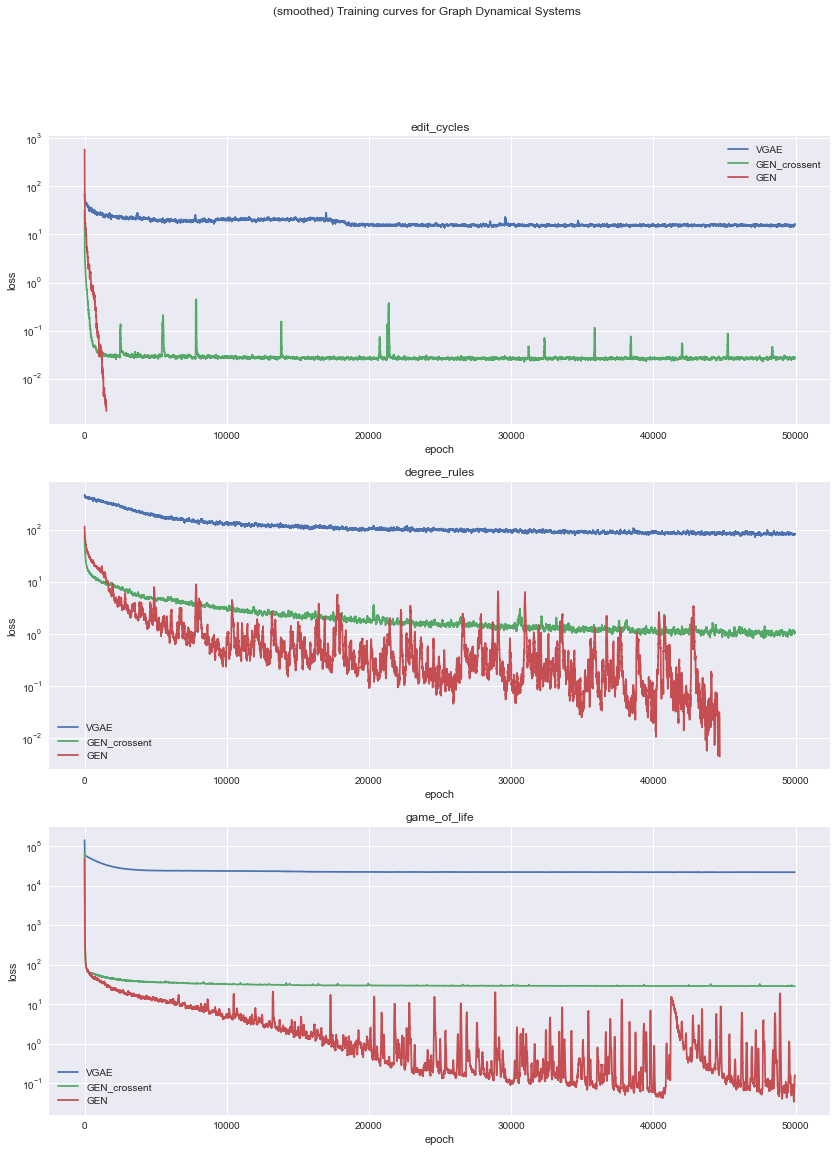

In [5]:
# visualize learning curves
import matplotlib.pyplot as plt
plt.style.use('seaborn')
smoothing_steps = 50
fig, axes = plt.subplots(ncols=1, nrows=len(datasets),figsize=(14,18))
for d in range(len(datasets)):
    for k in range(len(models)):
        curves_file  = 'results/%s_%s_learning_curves.csv' % (datasets[d], models[k])
        learning_curves = np.loadtxt(curves_file, delimiter = '\t')
        acum = np.cumsum(np.nanmean(learning_curves, 1))
        axes[d].semilogy((acum[smoothing_steps:] - acum[:-smoothing_steps])/smoothing_steps)
    axes[d].set_xlabel('epoch')
    axes[d].set_ylabel('loss')
    axes[d].set_title(datasets[d])
    axes[d].legend(models)
plt.suptitle('(smoothed) Training curves for Graph Dynamical Systems')
plt.savefig('results/learning_curves')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'results/degree_rules_GEN_hinge_results.csv'

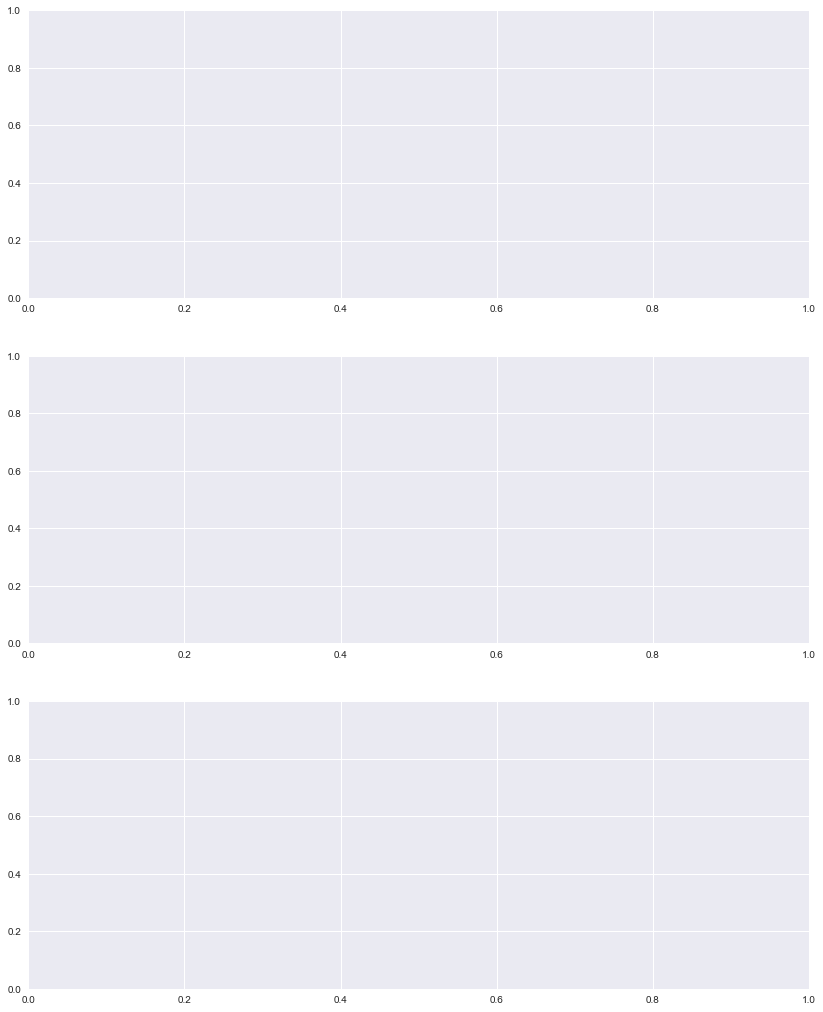

In [6]:
import pandas as pd

methods = ['VGAE', 'GEN_crossent', 'GEN_hinge']
datasets = ['degree_rules', 'edit_cycles', 'gam_of_life']
fig, axes = plt.subplots(ncols=1, nrows=len(methods),figsize=(14,18))
d = {'node_ins_recall' : []}
for i1, ds in enumerate(datasets):
    for i2, method in enumerate(methods):
        df = pd.read_csv(f'results/{ds}_{method}_results.csv')